# Imports

In [4]:
import gym
import rubiks
import rubiks2

import random
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os 
import copy
import time

from collections import defaultdict, deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from replay_memories import ReplayMemory, PrioritizedReplayMemory
from networks import DQN, DuelingDQN, DuelingDQNHER

from tqdm import tqdm_notebook
from EXP3S import EXP3S

from MCTS import MonteCarloSearchTree

from superflip import superflip_set

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Torch Version: ", torch.__version__)

Device:  cuda
Torch Version:  1.0.1.post2


In [6]:
model = DuelingDQN(144, [4096, 2048, 512], 6, F.elu)
os.mkdir('models/Random/')
torch.save(model, 'models/Random/' + "model.pt")

FileExistsError: [Errno 17] File exists: 'models/Random/'

# Epsilon

In [7]:
# Epsilon decay
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100

epsilon_by_exponential_step = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step_idx / epsilon_decay)

epsilon_by_linear_step = lambda step_idx: epsilon_final + (epsilon_start-epsilon_final)*((epsilon_decay-step_idx)/epsilon_decay) if step_idx < epsilon_decay else epsilon_final

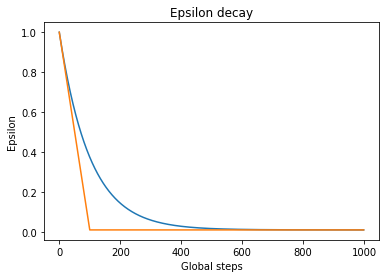

In [8]:
plt.figure
plt.title('Epsilon decay')
plt.xlabel('Global steps')
plt.ylabel('Epsilon')
plt.plot([epsilon_by_exponential_step(i) for i in range(1000)])
plt.plot([epsilon_by_linear_step(i) for i in range(1000)])

# Reward Scaling

In [9]:
# Scales rewards. Have emailed about how to implement for when there is no history or an history of 1 reward. 
# No answer as of yet, but my guess is that returning 0 will not affect the probabilites
def scale_reward(unscaled_reward, history_unscaled_rewards):
    if not history_unscaled_rewards:
        return 0

    q_lo = np.quantile(history_unscaled_rewards, 0.2)
    q_hi = np.quantile(history_unscaled_rewards, 0.8)
    
    if unscaled_reward < q_lo:
        return -1
    
    if unscaled_reward > q_hi:
        return 1
    
    if q_lo == q_hi:
        return 0
    
    return (2*(unscaled_reward - q_lo)/(q_hi-q_lo)) - 1

In [10]:
# Computes the q-values of an action in a state
def compute_q_val(model, state, action):
    qactions = model(state)
    return torch.gather(qactions,1,action.view(-1,1))

In [11]:
# Computes the target. When done, 0 is added to the reward as there is no next state.
def compute_target_dqn(model, reward, next_state, done, gamma):
    return reward + gamma * model(next_state).max(1)[0] * (1-done)

# Computes the target. When done, 0 is added to the reward as there is no next state. But now for Double DQN
def compute_target_ddqn(model, target_model, reward, next_state, done, gamma):
    a = model(next_state)
    return reward.view(-1,1) + gamma * torch.gather(target_model(next_state),1,model(next_state).max(1)[1].view(-1,1)) * (1-done).view(-1,1)

# Training classes

In [37]:
class Train(object):
    def __init__(self, architecture, duelingDQN, doubleDQN, lr, frames, batch_size, gamma, capacity_increase, 
                        tau, non_linearity,
                        verbose=False, load_path=None, save_path=None, seed=None, mode='14'):
        
        self.make_path(save_path)
        
        self.set_seed(seed)
        self.mode = mode
        
        # Arrays to keep track of losses and accuracies over time
        self.losses = []
        self.accuracies = []
        
        # Global steps keeps track of the total number of optimisation steps
        self.global_steps = 0
        # Local steps keeps track of number of optimisation steps within a task
        self.local_steps = 0
        
        # Epsilon exponential decay
        self.epsilon_start = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 10000
        
        self.frames = frames
        
        self.verbose = verbose
        
        self.criterion = torch.nn.SmoothL1Loss(reduce=False)
    
    def make_path(self, save_path):
        # If the directory does not exist, make one
        if save_path:
            if not os.path.isdir(save_path):
                os.mkdir(save_path)
                
    def set_seed(self, seed):
        # If a seed is set, set the seed for all sources of randomness
        if seed:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
    
    def calculate_max_moves_from_difficulty(self, difficulty):
        if self.mode is '14':
            return difficulty
        else:
            return difficulty // 6 + 1
    
    def calculate_max_moves_from_scrambles(self, scrambles):
        if self.mode is '14':
            return min(scrambles, 14)
        else:
            return min(scrambles // 6 + 1, 14)
            
    def initialise_models(self, load_path):
        raise NotImplementedError('Override initialise_models method in child class')
    
    def train(self):
        raise NotImplementedError('Override train method in child class')

# Handcrafted Curricula

In [43]:
class TrainHandcrafted(Train):
    def __init__(self, architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, frames, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity,
                        verbose=False, load_path=None, save_path=None, seed=None, mode='14'):
        super().__init__(architecture, duelingDQN, doubleDQN, lr, frames, batch_size, gamma, capacity_increase, tau, non_linearity,
                        verbose=verbose, load_path=load_path, save_path=save_path, seed=seed, mode=mode)
        
        print(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, frames, batch_size, gamma,
                        threshold, evaluation_frequency, tau, curriculum, non_linearity, mode)
        print([cap(1) for cap in capacity_increase])
        
        # Difficulty the problem starts with
        if mode=='14':
            self.difficulty = 1
        else:
            self.difficulty = 0
        
        # Initialise current and target model
        self.initialise_models(load_path)
        self.models_to_device()
        
        # Initialise replay memory
        self.memoryCapacity = memoryCapacity
        self.initialise_memory(prioritizedReplayMemory, self.memoryCapacity, alpha)
        
        # Initialise optimiser
        self.optimizer = optim.Adam(self.current_model.parameters(), lr=lr)
        
        self.curriculum = curriculum
        self.batch_size = batch_size
        self.gamma = gamma
        self.save_path = save_path
        self.tau = tau
        self.evaluation_frequency = evaluation_frequency
        self.threshold = threshold
        self.capacity_increase = capacity_increase
        self.lr = lr
        
        self.steps = []
        self.changes = []
        
    def models_to_device(self):
        # Decide what device to put the models on
        if torch.cuda.is_available():
            self.current_model.to('cuda')
            self.target_model.to('cuda')
        else:
            self.current_model.to('cpu')
            self.target_model.to('cpu')
            
    def initialise_memory(self, prioritizedReplayMemory, memoryCapacity, alpha):
        # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
        if prioritizedReplayMemory:
            self.memory = PrioritizedReplayMemory(int(memoryCapacity), alpha)
        else:
            self.memory = ReplayMemory(int(memoryCapacity))
    
    def initialise_models(self, load_path):
        # If a path with a model is provided certain variables are loaded
        if load_path:
            self.current_model = torch.load(load_path + 'model.pt')
            self.target_model = copy.deepcopy(current_model)
        else:
            # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
            state_size = env.size**2 * 6**2

            # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
            self.output_nodes = 12
            if env.size == 2:
                self.output_nodes = 6

            # Initialising either a network with dueling architecture or regular network
            if duelingDQN:
                self.current_model = DuelingDQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DuelingDQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
            else:
                self.current_model = DQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
    
    def save_model_parameters(self):
        if self.save_path:
            torch.save(self.current_model, self.save_path + "model.pt")
                
    def get_state(self):
        # Decide what state to show the network next depending on the curriculum
        state = None
        max_tries = None
        
        if curriculum is 'Naive':
            if self.mode is '14':
                state = env.reset(self.difficulty)
            else:
                state = env.curriculum_reset(self.difficulty)
            max_tries = self.calculate_max_moves_from_scrambles(self.difficulty)
            
        elif curriculum is 'LBF':
            p = np.random.rand()
            
            if p < 0.2:
                scrambles = np.random.randint(1, 1000)
                state = env.reset(scrambles)
                max_tries = self.calculate_max_moves_from_scrambles(scrambles)
                
            else:
                if self.mode is '14':
                    state = env.reset(self.difficulty)
                else:
                    state = env.curriculum_reset(self.difficulty)
                max_tries = self.calculate_max_moves_from_scrambles(self.difficulty)
                
        elif curriculum is 'Mixed':
            scrambles = np.random.randint(1,1000)
            
            state = env.reset(scrambles)

            max_tries = self.calculate_max_moves_from_scrambles(scrambles)
            
        else:
            scrambles = 1000
            state = env.reset(scrambles)
            max_tries = self.calculate_max_moves_from_scrambles(scrambles)
            
        return state, max_tries
    
    def train_dqn(self):
        if len(self.memory)<self.batch_size:
            return None
        
        batch, indices, weights = self.memory.sample(self.batch_size, self.local_steps, device)

        state, action, reward, next_state, done = zip(*batch)

        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        done = torch.tensor(done, dtype=torch.float32, device=device)

        weights.to(device)

        self.optimizer.zero_grad()

        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)        

        loss = self.criterion(q_val, target.view(-1,1)) * weights.unsqueeze(1)

        prios = loss + 1e-5
        loss = loss.mean()

        loss.backward()
        
        # Also taken from higgsfield
        self.memory.update_priorities(indices, prios.detach().squeeze().abs().cpu().numpy().tolist())
        self.optimizer.step()

        return loss.item()
    
    def train_without_replay(self, state, action, next_state, reward, done):
        self.optimizer.zero_grad()

        state = torch.tensor([state], dtype=torch.float32, device=device)
        action = torch.tensor([action], dtype=torch.long, device=device)
        next_state = torch.tensor([next_state], dtype=torch.float32, device=device)
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        done = torch.tensor([done], dtype=torch.float32, device=device)

        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)

        difference = (q_val - target.view(-1,1))

        loss = difference.pow(2)
        loss = loss.mean()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self):
        accuracy = 0.0
        try:
            epsilon_by_step = lambda step_idx: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step_idx / self.epsilon_decay)
            for frame_idx in tqdm_notebook(range(self.frames)):
                frame_losses = []
                
                # Main RL loop
                state, max_tries = self.get_state()
                done = 0
                tries = 0
                
                while tries < max_tries and not done:
                    epsilon = epsilon_by_step(self.local_steps)
                    action = self.current_model.act(state, epsilon, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)
                    self.memory.push((state, action, reward, next_state, done))
                    
                    # Directly train on last tuple if no replay buffer is uses
                    if not replay:
                        
                        loss = self.train_without_replay(state, action, next_state, reward, done)
                        
                    # Use replay memory to train
                    if replay:
                        loss = self.train_dqn()
                        
                    self.global_steps += 1
                        
                    self.local_steps += 1

                    state = next_state

                    tries += 1
                
                if loss:
                    frame_losses.append(loss)   
                
                # Target model becomes the current model (Mnih)
                if self.global_steps % self.tau == 0:
                    self.target_model.load_state_dict(self.current_model.state_dict())
                    self.save_model_parameters()
                
                
                # Current model evaluated in raw fashion, i.e. no additional structures such as MCTS or second best
                if self.global_steps % self.evaluation_frequency == 0 and self.curriculum is not None:
                    total_done = 0
                    for i in range(100):
                        if mode is '14':
                            state = env.reset(self.difficulty)
                        else:
                            state = env.curriculum_reset(self.difficulty)
                        max_tries = self.calculate_max_moves_from_scrambles(self.difficulty)
    
                        done = 0
                        tries = 0
                        
                        while tries < max_tries and not done:
                            action = self.current_model.act(state, 0.0, [0]*env.action_space.n, device)
                            next_state, reward, done, info = env.step(action)
                            state = next_state    
                        
                            total_done += done
                            tries += 1
                        
                    accuracy = total_done/100
                    self.accuracies.append(accuracy)
                    self.steps.append(self.global_steps)
                    
                    # Increment the current difficulty when the accuracy threshold is surpassed
                    if accuracy >= self.threshold:
                        self.best_accuracy = 0
                        self.difficulty += 1
                        self.local_steps = 0
                        self.changes.append(self.global_steps)

                        epsilon_by_step = lambda step_idx: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step_idx / self.epsilon_decay)
                    
                    # Print information
                    if self.verbose:
                        clear_output(True)
                        print("Frame: ", frame_idx, "Global steps: ", self.global_steps)
                        print("Difficulty: ", self.difficulty, "Max tries:", self.calculate_max_moves_from_scrambles(self.difficulty))
                        print("Memory: ", len(self.memory), "epsilon: ", epsilon, "local steps: ", self.local_steps)
                        print("Accuracy: ", accuracy, "Threshold: ", self.threshold)
                        print(self.current_model)

            
        except KeyboardInterrupt:
            pass
        
        if self.save_path:
            torch.save(self.current_model, self.save_path + "model.pt")
        
        return self.difficulty, accuracy, self.accuracies, self.steps, self.changes

In [44]:
class TrainAutomated(Train):
    def __init__(self, architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, 
                        threshold, evaluation_frequency, tau, curriculum, non_linearity, PG_eta=10e-3, PG_beta=0, PG_epsilon=0.05,
                        verbose=False, load_path=None, save_path=None, seed=None):
        super().__init__(architecture, duelingDQN, doubleDQN, lr, epochs, batch_size, gamma, capacity_increase, tau, non_linearity,
                        verbose=verbose, load_path=load_path, save_path=save_path, seed=seed)
        
        print(architecture, duelingDQN, doubleDQN, prioritizedReplayMemory, alpha, 
                        memoryCapacity, lr, epochs, batch_size, gamma,
                        threshold, evaluation_frequency, tau, curriculum, non_linearity)
        

        
        # Initialise current and target model
        self.initialise_models(load_path)
        self.models_to_device()

        # Initialise optimiser
        self.optimizer = optim.Adam(self.current_model.parameters(), lr=lr)
        
        # Initialise replay memory
        self.memoryCapacity = memoryCapacity
        self.initialise_memory(prioritizedReplayMemory, self.memoryCapacity, alpha)

        self.gamma = gamma
        self.save_path = save_path
        self.tau = tau
        self.evaluation_frequency = evaluation_frequency

        self.capacity_increase = capacity_increase
        self.lr = lr
        self.batch_size = batch_size

        self.exp3s = exp3s = EXP3S(14, PG_eta, PG_beta, PG_epsilon)
    
        self.history_unscaled_rewards = deque(maxlen=100)
    
    def models_to_device(self):
        # Decide what device to put the models on
        if torch.cuda.is_available():
            self.current_model.to('cuda')
            self.target_model.to('cuda')
        else:
            self.current_model.to('cpu')
            self.target_model.to('cpu')
        
    def initialise_models(self, load_path):
        # If a path with a model is provided certain variables are loaded
        if load_path:
            self.current_model = torch.load(load_path + 'model.pt')
            self.target_model = copy.deepcopy(current_model)
        else:
            # n^2 per face, 6 faces, 6 colours one-hot encoded. 3x3x6x6=324, 2x2x6x6=144
            state_size = env.size**2 * 6**2

            # The number of output nodes is different for the 2x2x2. The move L is the same as the move R, except the orientation changes.
            self.output_nodes = 12
            if env.size == 2:
                self.output_nodes = 6

            # Initialising either a network with dueling architecture or regular network
            if duelingDQN:
                self.current_model = DuelingDQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DuelingDQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
            else:
                self.current_model = DQN(state_size, architecture, self.output_nodes, non_linearity)
                self.target_model = DQN(state_size, copy.copy(architecture), self.output_nodes, non_linearity)
    
    def initialise_memory(self, prioritizedReplayMemory, memoryCapacity, alpha):
        # Uses prioritized replay sampling when set to true, otherwise uniform replay sampling is used
        if prioritizedReplayMemory:
            self.memory = PrioritizedReplayMemory(int(memoryCapacity), alpha)
        else:
            self.memory = ReplayMemory(int(memoryCapacity))
    
    def save_model_parameters(self):
        if self.save_path:
            torch.save(self.current_model, self.save_path + "model.pt")
                
    def get_state(self):
        # Decide what state to show the network next depending on the curriculum
        scrambles = np.random.choice([i + 1 for i in range(14)],size=1, p=self.exp3s.sample_probabilities())[0]

        state = env.reset(scrambles)
        
        return state, scrambles
    
    def train_dqn(self):
        if len(self.memory)<self.batch_size:
            return None, None

        batch, indices, weights = self.memory.sample(self.batch_size, self.local_steps, device)

        state, action, reward, next_state, done = zip(*batch)

        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        done = torch.tensor(done, dtype=torch.float32, device=device)

        weights.to(device)

        self.optimizer.zero_grad()

        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)

        difference = (q_val - target.view(-1,1))

        loss_before = difference.pow(2)*weights
        loss_before = loss_before.mean()

        loss_before.backward()
        self.memory.update_priorities(indices, difference.detach().squeeze().abs().cpu().numpy().tolist())
        self.optimizer.step()
        
        q_val = compute_q_val(self.current_model, state, action)

        with torch.no_grad():
            if doubleDQN:
                target = compute_target_ddqn(self.current_model, self.target_model, reward, next_state, done, self.gamma)
            else:
                target = compute_target_dqn(self.target_model, reward, next_state, done, gamma)

        difference = (q_val - target.view(-1,1))

        loss_after = difference.pow(2)*weights
        loss_after = loss_after.mean()

        nu_PG = (loss_before - loss_after).item()

        return loss_before.item(), nu_PG
        
    def train(self):
        accuracy = 0.0
        
        try:
            epsilon_by_step = lambda step_idx: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step_idx / self.epsilon_decay)
            for epoch in tqdm_notebook(range(self.epochs)):
                epoch_losses = []
                
                # Main RL loop
                state, max_tries = self.get_state()
                done = 0
                tries = 0
                
                while tries < max_tries + 14 and not done:
                    epsilon = epsilon_by_step(self.local_steps)
                    action = self.current_model.act(state, epsilon, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)
                    self.memory.push((state, action, reward, next_state, done))
                
                    state = next_state
                    tries += 1
                    
                loss, nu_PG = self.train_dqn()
                
                if loss:
                    reward = scale_reward(nu_PG, self.history_unscaled_rewards)
            
                    self.history_unscaled_rewards.append(nu_PG)
                    self.exp3s.update_weights(reward, max_tries - 1)
                
                self.global_steps += 1
                
                if epoch%1000==0:
                    clear_output(True)
                    print(np.array(self.exp3s.sample_probabilities()))
                    print((-np.array(self.exp3s.sample_probabilities())).argsort()[:14])
                    
                    env.seed(420)
                    total_done = 0
                    for i in range(14):
                        for j in range(100):
                            state = env.reset(i + 1)
                            max_tries = self.calculate_max_moves_from_scrambles(i + 1)
                        
                            done = 0
                            tries = 0
                        
                            while tries < max_tries and not done:
                                action = self.current_model.act(state, 0.0, [0]*env.action_space.n, device)
                                next_state, reward, done, info = env.step(action)
                                state = next_state    

                                total_done += done
                                tries += 1
                    env.seed(None)
                        
                    accuracy = total_done/1400
                    print(accuracy)
        except KeyboardInterrupt:
            pass

/home/joe/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[4096, 2048, 512] True True True 0.5 1400000 0.001 100000 32 0.99 0.99 100 1000 LBF <function leaky_relu at 0x7f3af6fb71e0> 14x6
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

28 0.88


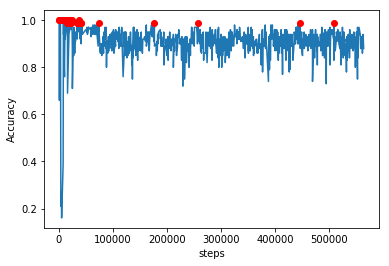

[4096, 2048, 512] True True True 0.5 1400000 0.001 100000 32 0.99 0.99 100 1000 Mixed <function leaky_relu at 0x7f3af6fb71e0> 14x6
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

8 0.64


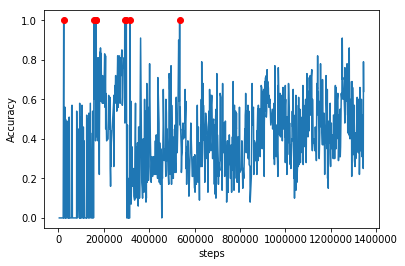

[4096, 2048, 512] True True True 0.5 1400000 0.001 100000 32 0.99 0.99 100 1000 Naive <function leaky_relu at 0x7f3af6fb71e0> 14x6
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

36 0.92


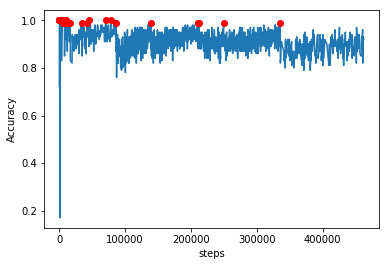

[4096, 2048, 512] True True True 0.5 1400000 0.001 100000 32 0.99 0.99 100 1000 None <function leaky_relu at 0x7f3af6fb71e0> 14x6
[0, 0, 0]


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

2 0.0


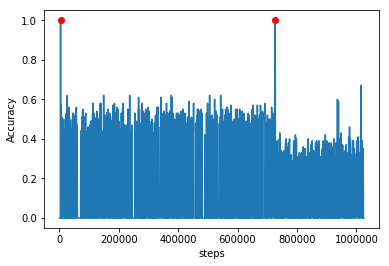

In [45]:
np.set_printoptions(4)
experiments = []
epochs = 100*1000

# experiments.append(["LBF_14", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'LBF', F.leaky_relu, '14'])
# experiments.append(["Mixed_14", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'Mixed', F.leaky_relu, '14'])
# experiments.append(["Naive_14", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'Naive', F.leaky_relu, '14'])
# experiments.append(["None_14", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'None', F.leaky_relu, '14'])

experiments.append(["LBF_14x6", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'LBF', F.leaky_relu, '14x6'])
experiments.append(["Mixed_14x6", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'Mixed', F.leaky_relu, '14x6'])
experiments.append(["Naive_14x6", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'Naive', F.leaky_relu, '14x6'])
experiments.append(["None_14x6", [4096, 2048, 512], True, True, True, True, 0.5, 14*100000, 1e-3, epochs, 32, 0.99, [lambda x: 0, lambda x: 0, lambda x: 0], 0.99, 100, 1000, 'None', F.leaky_relu, '14x6'])

for experiment in experiments:
    architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, mode = experiment[1:]

    env = rubiks2.RubiksEnv2(2, unsolved_reward = -1.0)

    trainer = TrainHandcrafted(architecture, duelingDQN, doubleDQN, replay, prioritizedReplayMemory, alpha, memoryCapacity, lr, epochs, batch_size, gamma, capacity_increase, threshold, evaluation_frequency, tau, curriculum, non_linearity, save_path='models/'+experiment[0]+'/', seed=40, verbose=False, mode=mode)
    
    difficulty, accuracy, accuracies, steps, changes = trainer.train()
    
    np.save('models/'+experiment[0]+'/accuracies.npy', accuracies)
    np.save('models/'+experiment[0]+'/steps.npy', steps)
    np.save('models/'+experiment[0]+'/changes.npy', changes)

    print(difficulty, accuracy)
    
    plt.figure()
    plt.plot(steps, accuracies)
    plt.xlabel('steps')
    plt.ylabel('Accuracy')
    for change in changes:
        idx = steps.index(change)
        plt.plot(steps[idx], accuracies[idx], 'ro')
    plt.show()

In [48]:
def maxDistance(arr): 
      
    # Used to store element to first index mapping 
    mp = {} 
  
    # Traverse elements and find maximum distance between 
    # same occurrences with the help of map. 
    maxDict = 0
    maxFirst_idx = 0
    for i in range(len(arr)): 
  
        # If this is first occurrence of element, insert its 
        # index in map 
        if arr[i] not in mp.keys(): 
            mp[arr[i]] = i 
  
        # Else update max distance 
        else: 
            if i-mp[arr[i]]>maxDict:
                maxDict = max(maxDict, i-mp[arr[i]])
                maxFirst_idx = mp[arr[i]]
  
    return maxDict, maxFirst_idx

In [51]:
def mcts_test(network, superflip, fifteen, thousand, max_tries=None):
    print('MCTS, superflip')
    c = 4.0
    nu = 10.0

    solve_rate_superflip = np.zeros(14)
    counts_superflip = np.zeros(14)
    seq_len_superflip = np.zeros(14)

    try:
        for i in range(14):
            hashes = []
            if i > 0:
                if solve_rate_superflip[i-1]==0:
                    break

            for sequence in tqdm_notebook(superflip_set):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)

                hashed_sequence = hash(str(sequence[:i+1]))

                if not hashed_sequence in hashes:

                    hashes.append(hashed_sequence)


                    counts_superflip[i] += 1

                    for j in range(i + 1):
                        env.step(sequence[j])

                    MCTS = MonteCarloSearchTree(env, network, 1.21, device, c, nu)
                    solved, solve_sequence = MCTS.search()
                    solve_rate_superflip[i] += solved

                    if solved:
                        seq_len_superflip[i] += len(solve_sequence)

    except KeyboardInterrupt:
        pass
    print('MCTS, 15 scrambles')
    solve_rate_15 = 0
    counts_15 = 0
    seq_len_15 = 0

    try:
        for i in tqdm_notebook(range(640)):
            env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)
            env.reset(15)

            counts_15 += 1

            MCTS = MonteCarloSearchTree(env, network, 1.21, device, c, nu)
            solved, solve_sequence = MCTS.search()
            solve_rate_15 += solved

            if solved:
                seq_len_15 += len(solve_sequence)

    except KeyboardInterrupt:
        pass
    
    solve_rate_1000 = 0
    counts_1000 = 0
    seq_len_1000 = 0

    try:
        for i in tqdm_notebook(range(640)):
            env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)
            env.reset(1000)

            counts_1000 += 1

            MCTS = MonteCarloSearchTree(env, network, 1.21, device, c, nu)
            solved, solve_sequence = MCTS.search()
            solve_rate_1000 += solved

            if solved:
                seq_len_1000 += len(solve_sequence)

    except KeyboardInterrupt:
        pass

    return (np.divide(solve_rate_superflip, counts_superflip),
np.divide(seq_len_superflip, solve_rate_superflip),
np.array(solve_rate_15)/np.array(counts_15),
np.array(seq_len_15)/np.array(solve_rate_15),
np.array(solve_rate_1000)/np.array(counts_1000),
np.array(seq_len_1000)/np.array(solve_rate_1000))
    
def second_best_test(network, superflip, fifteen, thousand, max_tries=None):
    print('Second best, superflip')
    c = 4.0
    nu = 10.0

    solve_rate_superflip = np.zeros(14)
    counts_superflip = np.zeros(14)
    seq_len_superflip = np.zeros(14)
    seq_len_superflip_heur = np.zeros(14)
    puzzles = []
    solution_sequences = []
    
    if superflip:
        try:
            for i in range(14):
                hashes_seqs = []
                if i > 0:
                    if solve_rate_superflip[i-1]==0:
                        break

                for sequence in tqdm_notebook(superflip_set):
                    env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)

                    hashed_sequence = hash(str(sequence[:i+1]))

                    if not hashed_sequence in hashes_seqs:

                        hashes_seqs.append(hashed_sequence)


                        counts_superflip[i] += 1
                        
                        puzzle = []
                        for j in range(i + 1):
                            env.step(int(sequence[j]))
                            puzzle.append(sequence[j])
                        
                        puzzles.append(puzzle)
                            
                        hashes = defaultdict(list)
                        done = 0
                        tries = 0
                        t = time.time()
                        state = env.get_observation()
                        hashes[hash(state.tostring())] = [0]*env.action_space.n
                        stop = False
                        
                        solution_sequence = []
                        state_hash_seq = []
                        
                        while time.time()-t<1.21 and not done and not stop:
                            mask = hashes[hash(state.tostring())]
                            state_hash_seq.append(hash(state.tostring()))
                            action = network.act(state, 0.0, mask, device)
                            solution_sequence.append(action)
                            
                            next_state, reward, done, info = env.step(action)  

                            hstate = state.copy()
                            state = next_state
                            h = hash(state.tostring())
                            if h in hashes.keys():      
                                hashes[hash(hstate.tostring())][action] = -999
                            else:
                                hashes[h] = [0]*env.action_space.n

                            tries += 1
                            if max_tries:
                                if tries >= max_tries:
                                    stop = True
                        
                        length, first_idx = maxDistance(state_hash_seq)
                        
                        while length > 0:
                            state_hash_seq = state_hash_seq[:first_idx] + state_hash_seq[first_idx + length:]
                            solution_sequence = solution_sequence[:first_idx] + solution_sequence[first_idx + length:]
                            length, first_idx = maxDistance(state_hash_seq)
                            
                        solution_sequences.append(solution_sequence)
                        solve_rate_superflip[i] += done

                        if done:
                            seq_len_superflip[i] += tries
                            seq_len_superflip_heur[i] += len(solution_sequence)

        except KeyboardInterrupt:
            pass
    
    print('Second best network, 15 scrambles')
    solve_rate_15 = 0
    counts_15 = 0
    seq_len_15 = 0
    
    if fifteen:
        try:
            for i in tqdm_notebook(range(640)):
                hashes = defaultdict(list)
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(15)
                t = time.time()

                counts_15 += 1
                
                hashes = defaultdict(list)
                done = 0
                tries = 0
                state = env.get_observation()
                hashes[hash(state.tostring())] = [0]*env.action_space.n
                while time.time()-t<1.21 and not done:
                    mask = hashes[hash(state.tostring())]
                    action = network.act(state, 0, mask, device)
                    next_state, reward, done, info = env.step(action)  

                    hstate = state.copy()
                    state = next_state
                    h = hash(state.tostring())
                    if h in hashes.keys():
                        hashes[hash(hstate.tostring())][action] = -999
                    else:
                        hashes[h] = [0]*env.action_space.n

                    tries += 1


                solve_rate_15 += done
            

                if done:
                    seq_len_15 += tries

        except KeyboardInterrupt:
            pass
    
    print('Second best network, 1000 scrambles')
    solve_rate_1000 = 0
    counts_1000 = 0
    seq_len_1000 = 0
    
    if thousand:
        try:
            for i in tqdm_notebook(range(640)):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(1000)
                t = time.time()

                counts_1000 += 1

                hashes = defaultdict(list)
                done = 0
                tries = 0
                t = time.time()
                state = env.get_observation()
                hashes[hash(state.tostring())] = [0]*env.action_space.n
                stop = False

                while time.time()-t<1.21 and not done and not stop:
                    mask = hashes[hash(state.tostring())]
                    action = network.act(state, 0.0, mask, device)

                    next_state, reward, done, info = env.step(action)  

                    hstate = state.copy()
                    state = next_state
                    h = hash(state.tostring())
                    if h in hashes.keys():      
                        hashes[hash(hstate.tostring())][action] = -999
                    else:
                        hashes[h] = [0]*env.action_space.n

                    tries += 1
                    if max_tries:
                        if tries >= max_tries:
                            stop = True


                solve_rate_1000 += done

                if done:
                    seq_len_1000 += tries

        except KeyboardInterrupt:
            pass
    
    score = np.zeros(14)
    solve_rate = np.divide(solve_rate_superflip, counts_superflip)
    seq_len = np.divide(seq_len_superflip, solve_rate_superflip)
    for i in range(14):
        score[i] = solve_rate[i] / (1+(seq_len[i] - (i+1)))
        
    score = np.mean(score) - np.std(score)
    
    return (np.mean(np.divide(solve_rate_superflip, counts_superflip))-np.std(np.divide(solve_rate_superflip, counts_superflip)),
            score,
            np.divide(solve_rate_superflip, counts_superflip),
np.divide(seq_len_superflip, solve_rate_superflip),
            np.divide(seq_len_superflip_heur, solve_rate_superflip),
np.array(solve_rate_15)/np.array(counts_15),
np.array(seq_len_15)/np.array(solve_rate_15),
np.array(solve_rate_1000)/np.array(counts_1000),
np.array(seq_len_1000)/np.array(solve_rate_1000),
           puzzles, solution_sequences)

def raw_test(network, superflip, fifteen, thousand, max_tries=None):
    print('Raw network, superflip')
    c = 4.0
    nu = 10.0

    solve_rate_superflip = np.zeros(14)
    counts_superflip = np.zeros(14)
    seq_len_superflip = np.zeros(14)
    
    if superflip:
        try:
            for i in range(14):
                hashes_seqs = []
                if i > 0:
                    if solve_rate_superflip[i-1]==0:
                        solve_rate_superflip[i] = 0
                        break

                for sequence in tqdm_notebook(superflip_set):
                    env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0)

                    hashed_sequence = hash(str(sequence[:i+1]))

                    if not hashed_sequence in hashes_seqs:

                        hashes_seqs.append(hashed_sequence)


                        counts_superflip[i] += 1

                        for j in range(i + 1):
                            env.step(sequence[j])

                        done = 0
                        tries = 0
                        t = time.time()
                        state = env.get_observation()
                        while time.time()-t<1.21 and not done:
                            action = network.act(state, 0.0, [0]*env.action_space.n, device)
                            next_state, reward, done, info = env.step(action)  

                            state = next_state

                            tries += 1
                            if max_tries:
                                if tries >= max_tries:
                                    stop = True

                        solve_rate_superflip[i] += done

                        if done:
                            seq_len_superflip[i] += tries

        except KeyboardInterrupt:
            pass
    
    print('Raw network, 15 scrambles')
    solve_rate_15 = 0
    counts_15 = 0
    seq_len_15 = 0
    
    if fifteen:
        try:
            for i in tqdm_notebook(range(640)):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(15)
                t = time.time()

                counts_15 += 1

                done = 0
                tries = 0

                state = env.get_observation()
                while time.time()-t<1.21 and not done:
                    action = network.act(state, 0.0, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)  

                    state = next_state

                    tries += 1


                solve_rate_15 += done

                if done:
                    seq_len_15 += tries

        except KeyboardInterrupt:
            pass
    
    print('Raw network, 1000 scrambles')
    solve_rate_1000 = 0
    counts_1000 = 0
    seq_len_1000 = 0
    
    if thousand:
        try:
            for i in tqdm_notebook(range(640)):
                env = rubiks2.RubiksEnv2(2, unsolved_reward=-1.0, seed=i)
                env.reset(1000)
                t = time.time()

                counts_1000 += 1

                done = 0
                tries = 0
                state = env.get_observation()
                while time.time()-t<1.21 and not done:
                    action = network.act(state, 0.0, [0]*env.action_space.n, device)
                    next_state, reward, done, info = env.step(action)  

                    state = next_state

                    tries += 1


                solve_rate_1000 += done

                if done:
                    seq_len_1000 += tries

        except KeyboardInterrupt:
            pass

    score = np.zeros(14)
    solve_rate = np.divide(solve_rate_superflip, counts_superflip)
    seq_len = np.divide(seq_len_superflip, solve_rate_superflip)
    for i in range(14):
        score[i] = solve_rate[i] / (1+(seq_len[i] - (i+1)))
        if np.isnan(score[i]):
            score[i] = 0
        
    score = np.mean(score) - np.std(score)
    
    return (np.mean(np.divide(solve_rate_superflip, counts_superflip))-np.std(np.divide(solve_rate_superflip, counts_superflip)),
            score, 
            np.divide(solve_rate_superflip, counts_superflip),
np.divide(seq_len_superflip, solve_rate_superflip),
np.array(solve_rate_15)/np.array(counts_15),
np.array(seq_len_15)/np.array(solve_rate_15),
np.array(solve_rate_1000)/np.array(counts_1000),
np.array(seq_len_1000)/np.array(solve_rate_1000))

def test(experiment_name, raw, second_best, mcts):
    network = torch.load('./models/' + experiment_name + '/model.pt', map_location='cpu')
    network.to(device)
    max_tries = 1000
    superflip = True
    fifteen = False
    thousand = False
    if raw:
        score, score_normalised, solve_rate, seq_len, solve_rate15, seq_len15, solve_rate1000, seq_len1000 = raw_test(network, superflip, fifteen, thousand, max_tries)
        print(score, score_normalised, solve_rate, seq_len, solve_rate15, seq_len15, solve_rate1000, seq_len1000)
    if second_best:
        score, score_normalised, solve_rate, seq_len, seq_len_heur, solve_rate15, seq_len15, solve_rate1000, seq_len1000, puzzles, solution_sequences = second_best_test(network, superflip, fifteen, thousand, max_tries)
        print(score, score_normalised, solve_rate, seq_len, seq_len_heur, solve_rate15, seq_len15, solve_rate1000, seq_len1000)
    if mcts:
        score, _, _, _,_,_,_ = mcts_test(network, superflip, fifteen, thousand, max_tries)
        print(score)
    return puzzles, solution_sequences
    

In [53]:
test_strings = ['LBF_14', 'Mixed_14', 'Naive_14']
for test_string in test_strings:
    print(test_string)
    test(test_string, True, True, False)

LBF_14
Raw network, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Raw network, 15 scrambles
Raw network, 1000 scrambles
nan -0.051650363036831126 [1.     0.963  0.9706 0.9412 0.8543 0.5506 0.292  0.1168 0.0328 0.0073
 0.0036 0.        nan    nan] [ 1.      2.      3.      4.0104  5.1475  6.381   7.975   9.625   9.6667
 13.     13.         nan     nan     nan] nan nan nan nan
Second best, superflip


/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:419: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:420: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:428: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:429: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:430: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:431: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:432: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:433: R

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles
Second best network, 1000 scrambles
0.9735899201476 -0.11802748081036948 [1.     1.     1.     1.     1.     1.     0.9927 0.9818 0.9818 0.9745
 0.9709 0.9564 0.9745 0.9891] [  1.       3.1852   3.9412   7.0098  15.7008  81.6554 138.3676 190.
 235.1413 254.6292 276.5581 281.3156 275.1567 270.0147] [  1.       2.4444   3.3529   5.1863   9.3071  34.1648  56.2721  77.368
  93.2677 100.0524 105.4569 109.0875 105.2164 103.1136] nan nan nan nan
Mixed_14
Raw network, superflip


/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in true_divide


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Raw network, 15 scrambles
Raw network, 1000 scrambles
nan -0.049305530659527044 [0.3333 0.3333 0.1569 0.0637 0.0236 0.        nan    nan    nan    nan
    nan    nan    nan    nan] [1.     2.4444 3.375  5.0769 6.6667    nan    nan    nan    nan    nan
    nan    nan    nan    nan] nan nan nan nan
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles
Second best network, 1000 scrambles
nan nan [0.8333 0.8148 0.5    0.1667 0.0472 0.0112 0.0109 0.0036 0.        nan
    nan    nan    nan    nan] [ 15.4     14.4545  17.4314  18.4118  16.3333  37.3333  62.3333 162.
      nan      nan      nan      nan      nan      nan] [ 1.8     3.1818  4.6078  5.9412  7.8333 14.     22.3333 70.         nan
     nan     nan     nan     nan     nan] nan nan nan nan
Naive_14
Raw network, superflip


/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:275: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:276: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:285: RuntimeWarning: invalid value encountered in true_divide
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in true_divide


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Raw network, 15 scrambles
Raw network, 1000 scrambles
nan -0.028750375470555145 [1.     1.     1.     1.     0.9961 0.8577 0.4562 0.2044 0.073  0.0146
 0.0109 0.        nan    nan] [ 1.      2.      3.      4.      5.0237  6.2358  8.184   9.4286 11.3
 13.     13.6667     nan     nan     nan] nan nan nan nan
Second best, superflip


HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

HBox(children=(IntProgress(value=0, max=276), HTML(value='')))

Second best network, 15 scrambles
Second best network, 1000 scrambles
1.0 -0.10968554144777787 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [  1.       2.       3.       4.       5.4252  28.1798 109.7664 169.7883
 203.146  224.6788 221.8218 229.3309 238.2655 242.2246] [ 1.      2.      3.      4.      5.2205 15.2135 49.0876 72.2847 86.9197
 95.2336 92.8836 94.3636 97.4364 98.2971] nan nan nan nan
